# Co-Culture Simulation 

In [1]:
import os
# Change the paths to your installation locations
#os.environ['GUROBI_COMETS_HOME'] = '/Library/gurobi1003/macos_universal2'
os.environ['GUROBI_COMETS_HOME'] = '/Library/gurobi952/macos_universal2'
#os.environ['COMETS_HOME'] = '/Users/fredericksenya/Documents/MATLAB/comets_macos/comets_2.12.3'
#os.environ['CLASSPATH'] = f"{os.environ['COMETS_HOME']}/comets.jar:{os.environ['GUROBI_COMETS_HOME']}/lib/gurobi.jar"
#os.environ['DYLD_LIBRARY_PATH'] = f"{os.environ['GUROBI_COMETS_HOME']}/lib"
#os.environ['GRB_LICENSE_FILE'] = '/Library/gurobi1003/macos_universal2/gurobi.lic'

import cobra as cb
import cometspy as c
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

In [2]:
VOL = 1e-3                        # cm³  
SPACE_WIDTH = VOL ** (1/3)         # 0.1 cm = 1 mm
BOX_VOL_CM3 = SPACE_WIDTH ** 3     # VOL
BOX_VOL_L  = BOX_VOL_CM3 * 1e-3   # 1e-6 L

def mM_to_mmol(conc_mM):
    'concentration to mmol'
    return conc_mM * BOX_VOL_L

def mmol_to_mM(amount_mmol):
    'mmol to concentration'
    return amount_mmol / BOX_VOL_L

# parameters
DEFAULT_VMAX = 20.0       # mmol/gDW/h
DEFAULT_KM   = 5e-4       # mmol/cm³  (= 0.5 mM)
DEFAULT_HILL  = 1

TIME_STEP  = 0.01         
MAX_CYCLES = 150           
LOG_RATE   = 1           

t_step = TIME_STEP        
t_total = MAX_CYCLES

INIT_BIOMASS = 5e-7       # g  
MAX_SPACE_BIOMASS = 1e-2  # g
MIN_SPACE_BIOMASS = 1e-14 # g

# concentrations 
GLC_CONC_mM  = 10.0      # glucose
NH4_CONC_mM  = 5.0       # ammonium
ION_CONC_mM  = 5.0       # major ions
AA_CONC_mM   = 2.0       # amino acids
TRACE_CONC_mM = 0.1      # trace metals & vitamins
WATER_AMOUNT  = 1e-4     # mmol 

# media
water_proton_ids = {'h2o[e]'}
major_ion_ids    = {'pi[e]', 'so4[e]', 'k[e]', 'cl[e]', 'mg2[e]', 'ca2[e]'}
trace_metal_ids  = {'fe2[e]', 'fe3[e]', 'zn2[e]', 'cu2[e]', 'mn2[e]', 'cobalt2[e]', 'cd2[e]'}
vitamin_ids      = {'ribflv[e]', 'pnto_R[e]', 'nac[e]', 'hxan[e]'}
aa_ids           = {'ala_L[e]', 'asn_L[e]', 'his_L[e]', 'leu_L[e]', 'lys_L[e]',
                    'met_L[e]', 'glycys[e]', 'glyglu[e]'}

# Combined set 
background_met_ids = water_proton_ids | major_ion_ids | trace_metal_ids | vitamin_ids | aa_ids | {'nh4[e]'}


def classify_and_set_media(layout, all_ex_mets):

    for met in all_ex_mets:
        layout.set_specific_metabolite(met, 0.0)
        layout.set_specific_refresh(met, 0.0)

    for met in all_ex_mets:
        if met in water_proton_ids:
            layout.set_specific_metabolite(met, WATER_AMOUNT)
            layout.set_specific_static(met, WATER_AMOUNT)
        elif met in major_ion_ids:
            layout.set_specific_metabolite(met, mM_to_mmol(ION_CONC_mM))
            layout.set_specific_static(met, mM_to_mmol(ION_CONC_mM))
        elif met in trace_metal_ids:
            layout.set_specific_metabolite(met, mM_to_mmol(TRACE_CONC_mM))
            layout.set_specific_static(met, mM_to_mmol(TRACE_CONC_mM))
        elif met in vitamin_ids:
            layout.set_specific_metabolite(met, mM_to_mmol(TRACE_CONC_mM))
            layout.set_specific_static(met, mM_to_mmol(TRACE_CONC_mM))
        elif met in aa_ids:
            layout.set_specific_metabolite(met, mM_to_mmol(AA_CONC_mM))
            layout.set_specific_static(met, mM_to_mmol(AA_CONC_mM))
        elif met == 'nh4[e]':
            layout.set_specific_metabolite(met, mM_to_mmol(NH4_CONC_mM))
            layout.set_specific_static(met, mM_to_mmol(NH4_CONC_mM))


def make_params():
   
    params = c.params()
    params.set_param('spaceWidth',       SPACE_WIDTH)
    params.set_param('defaultVmax',      DEFAULT_VMAX)
    params.set_param('defaultKm',        DEFAULT_KM)
    params.set_param('defaultHill',      DEFAULT_HILL)
    params.set_param('exchangestyle',    'Monod Style')
    params.set_param('timeStep',         TIME_STEP)
    params.set_param('maxCycles',        MAX_CYCLES)
    params.set_param('maxSpaceBiomass',  MAX_SPACE_BIOMASS)
    params.set_param('minSpaceBiomass',  MIN_SPACE_BIOMASS)
    params.set_param('writeMediaLog',    True)
    params.set_param('MediaLogRate',     LOG_RATE)
    params.set_param('writeFluxLog',     True)
    params.set_param('FluxLogRate',      LOG_RATE)
    params.set_param('writeBiomassLog',  True)
    params.set_param('BiomassLogRate',   LOG_RATE)
    return params


def clean_non_ex(comets_model):
    'COMETS bug fix'
    ex_mask = comets_model.reactions['EXCH'].isin([True, 'True'])
    for name in comets_model.reactions.loc[ex_mask, 'REACTION_NAMES']:
        name = str(name)
        if not name.startswith('EX_'):
            comets_model.reactions.loc[
                comets_model.reactions['REACTION_NAMES'] == name, 'EXCH'] = False
            comets_model.reactions.loc[
                comets_model.reactions['REACTION_NAMES'] == name, 'EXCH_IND'] = 0

print(f'Glucose: {GLC_CONC_mM} mM  → {mM_to_mmol(GLC_CONC_mM):.2e} mmol/box')

Glucose: 10.0 mM  → 1.00e-05 mmol/box


In [3]:
#Load COBRA models
base1 = cb.io.load_matlab_model('Bifidobacterium_longum_infantis_ATCC_15697.mat')
base1.id = 'Bifido'
base2 = cb.io.load_matlab_model('Eubacterium_hallii_DSM_3353.mat')
base2.id = 'Eubacterium'

#default bounds for all exchanges
for m in [base1, base2]:
    for rxn in m.exchanges:
        rxn.lower_bound = 0.0
        rxn.upper_bound = 1000.0

#metabolite to exchange reaction mappings
met_to_ex1 = {}
for rxn in base1.exchanges:
    if rxn.metabolites:
        met = list(rxn.metabolites.keys())[0]
        met_to_ex1[met.id] = rxn.id

met_to_ex2 = {}
for rxn in base2.exchanges:
    if rxn.metabolites:
        met = list(rxn.metabolites.keys())[0]
        met_to_ex2[met.id] = rxn.id

# Union of all external metabolites
all_ext_mets = set(met_to_ex1.keys()) | set(met_to_ex2.keys())

def add_missing_closed_exchanges(model, met_to_ex_self_real, all_ext_mets, label):
    'Comets bug fix'
    met_ids = {m.id for m in model.metabolites}
    rxn_ids = {r.id for r in model.reactions}

    for met_id in all_ext_mets:
        if met_id in met_to_ex_self_real:
            continue

        if met_id in met_ids:
            met = model.metabolites.get_by_id(met_id)
        else:
            met = cb.Metabolite(met_id, compartment='e')
            model.add_metabolites([met])
            met_ids.add(met_id)
            #print(f"[{label}] Added external metabolite {met_id}")

        rxn_id = f"EX_added_{met_id}"
        if rxn_id in rxn_ids:
            continue

        rxn = cb.Reaction(rxn_id)
        rxn.name = f"Dummy exchange for {met_id} (closed)"
        rxn.lower_bound = 0.0
        rxn.upper_bound = 0.0
        rxn.add_metabolites({met: -1.0})
        model.add_reactions([rxn])
        rxn_ids.add(rxn_id)
        #print(f"[{label}] Added CLOSED dummy exchange {rxn_id} for {met_id}")

add_missing_closed_exchanges(base1, met_to_ex1, all_ext_mets, "Bifido")
add_missing_closed_exchanges(base2, met_to_ex2, all_ext_mets, "Eubacterium")

Set parameter Username
Academic license - for non-commercial use only - expires 2027-02-19


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e
No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e


In [4]:
# COMETS models 
Comets_Bifido = c.model(base1)
Comets_Eubacterium = c.model(base2)

Comets_Bifido.open_exchanges()
Comets_Eubacterium.open_exchanges()

# Clean non-EX exchanges
for m in [Comets_Bifido, Comets_Eubacterium]:
    clean_non_ex(m)


Comets_Bifido.initial_pop = [0, 0, INIT_BIOMASS]
Comets_Eubacterium.initial_pop = [0, 0, INIT_BIOMASS]

# Layout
def create_layout(models):
    if not isinstance(models, list):
        models = [models]

    layout = c.layout()
    for model in models:
        layout.add_model(model)

    # Set media
    classify_and_set_media(layout, all_ext_mets)

    # Set glucose
    layout.set_specific_metabolite('glc_D[e]', mM_to_mmol(GLC_CONC_mM))
    layout.set_specific_refresh('glc_D[e]', 0.0)

    # track secreted metabolites
    for met in all_ext_mets:
        if met not in background_met_ids and met != 'glc_D[e]':
            layout.set_specific_metabolite(met, 0.0)

    return layout

In [5]:
# simulation

# Monoculture Bifido
print("Running Bifido monoculture...")
layout_mono_Bifido = create_layout(Comets_Bifido)
params_mono_b = make_params()
sim_mono_Bifido = c.comets(layout_mono_Bifido, params_mono_b)
sim_mono_Bifido.run()

# Monoculture Eubacterium
print("\nRunning Eubacterium monoculture...")
layout_mono_Eubacterium = create_layout(Comets_Eubacterium)
params_mono_e = make_params()
sim_mono_Eubacterium = c.comets(layout_mono_Eubacterium, params_mono_e)
sim_mono_Eubacterium.run()

# Co-culture
print("\nRunning co-culture...")
layout_co = create_layout([Comets_Bifido, Comets_Eubacterium])
params_co = make_params()
sim_co = c.comets(layout_co, params_co)
sim_co.run()


Running Bifido monoculture...
building empty layout model
models will need to be added with layout.add_model()

Running COMETS simulation ...
Done!

Running Eubacterium monoculture...
building empty layout model
models will need to be added with layout.add_model()

Running COMETS simulation ...
Done!

Running co-culture...
building empty layout model
models will need to be added with layout.add_model()

Running COMETS simulation ...
Done!


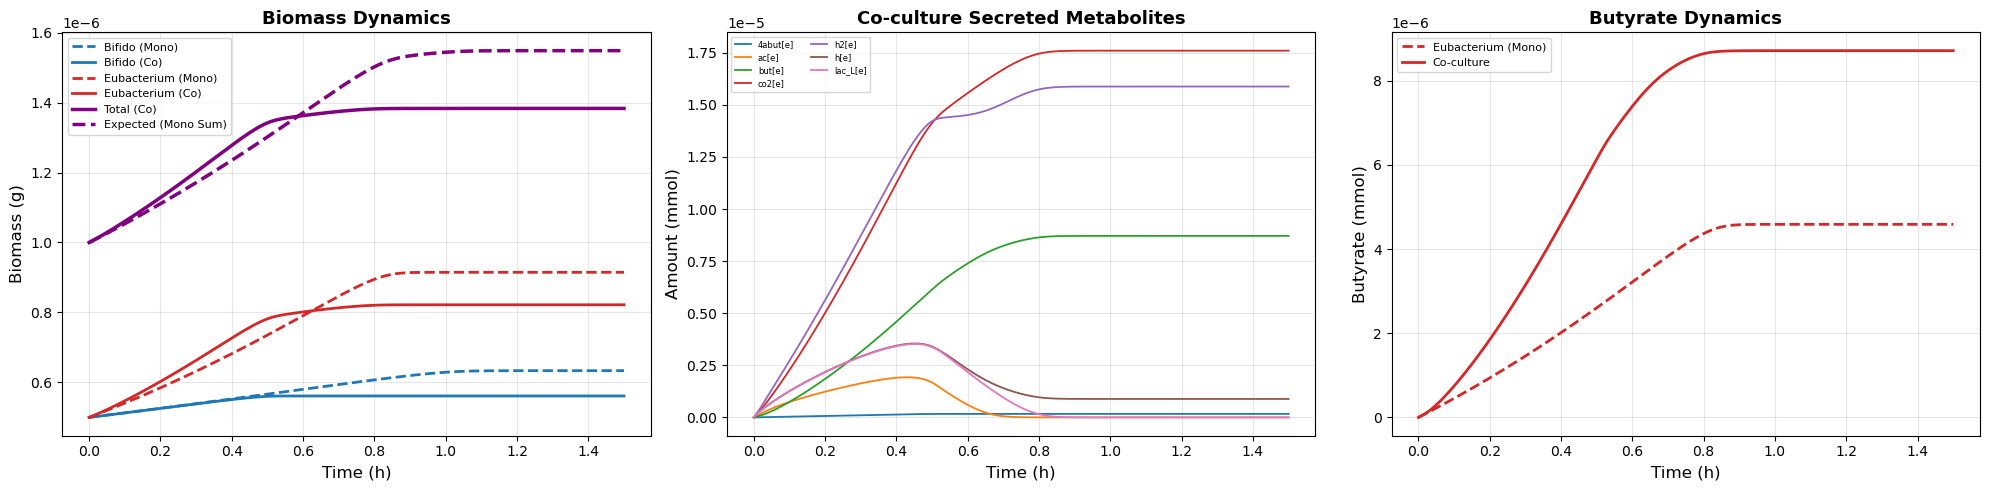

In [7]:
ts = sim_co.get_metabolite_time_series()

time_co = np.arange(len(sim_co.total_biomass)) * t_step
time_mono_b = np.arange(len(sim_mono_Bifido.total_biomass)) * t_step
time_mono_e = np.arange(len(sim_mono_Eubacterium.total_biomass)) * t_step

bif_co = sim_co.total_biomass['Bifido'].values
eub_co = sim_co.total_biomass['Eubacterium'].values
bif_mono = sim_mono_Bifido.total_biomass['Bifido'].values
eub_mono = sim_mono_Eubacterium.total_biomass['Eubacterium'].values

media_mono_e = sim_mono_Eubacterium.get_metabolite_time_series()
media_co = sim_co.get_metabolite_time_series()

but_mono = media_mono_e['but[e]'].values
but_co = media_co['but[e]'].values

fig, axes = plt.subplots(1, 3, figsize=(20, 5))

C_BIF = '#1f77b4'
C_EUB = '#d62728'
C_CO  = 'purple'
LS_CO   = '-'
LS_MONO = '--'

#Biomass 
ax = axes[0]
ax.plot(time_mono_b, bif_mono, color=C_BIF, ls=LS_MONO, lw=2, label='Bifido (Mono)')
ax.plot(time_co,     bif_co,   color=C_BIF, ls=LS_CO,   lw=2, label='Bifido (Co)')
ax.plot(time_mono_e, eub_mono, color=C_EUB, ls=LS_MONO, lw=2, label='Eubacterium (Mono)')
ax.plot(time_co,     eub_co,   color=C_EUB, ls=LS_CO,   lw=2, label='Eubacterium (Co)')
ax.plot(time_co,     bif_co + eub_co, color=C_CO, ls=LS_CO, lw=2.5, label='Total (Co)')
ax.plot(time_mono_b, bif_mono + eub_mono, color=C_CO, ls=LS_MONO, lw=2.5, label='Expected (Mono Sum)')
ax.set_xlabel('Time (h)', fontsize=12)
ax.set_ylabel('Biomass (g)', fontsize=12)
ax.set_title('Biomass Dynamics', fontsize=13, fontweight='bold')
ax.legend(fontsize=8)
ax.grid(True, alpha=0.3)

# Co-culture secreted metabolites
ax = axes[1]
time_ts = ts['cycle'].values * t_step
initial_media_mets = background_met_ids | {'glc_D[e]'}
secreted = [m for m in ts.columns if m != 'cycle' and m not in initial_media_mets and 'biomass' not in m.lower() and ts[m].max() > 0]

for m in sorted(secreted):
    y = ts[m].values
    if np.any(y > 1e-13): # only plot if there's a significant secretion
        ax.plot(time_ts, y, lw=1.3, label=m)

ax.set_xlabel('Time (h)', fontsize=12)
ax.set_ylabel('Amount (mmol)', fontsize=12)
ax.set_title('Co-culture Secreted Metabolites', fontsize=13, fontweight='bold')
ax.legend(fontsize=6, loc='upper left', ncol=2)
ax.grid(True, alpha=0.3)

#  Butyrate 
ax = axes[2]
ax.plot(time_mono_e, but_mono, color=C_EUB, ls=LS_MONO, lw=2, label='Eubacterium (Mono)')
ax.plot(time_co,     but_co,   color=C_EUB, ls=LS_CO,   lw=2, label='Co-culture')
ax.set_xlabel('Time (h)', fontsize=12)
ax.set_ylabel('Butyrate (mmol)', fontsize=12)
ax.set_title('Butyrate Dynamics', fontsize=13, fontweight='bold')
ax.legend(fontsize=8)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('coculture_summary.png', dpi=150, bbox_inches='tight')
plt.show()

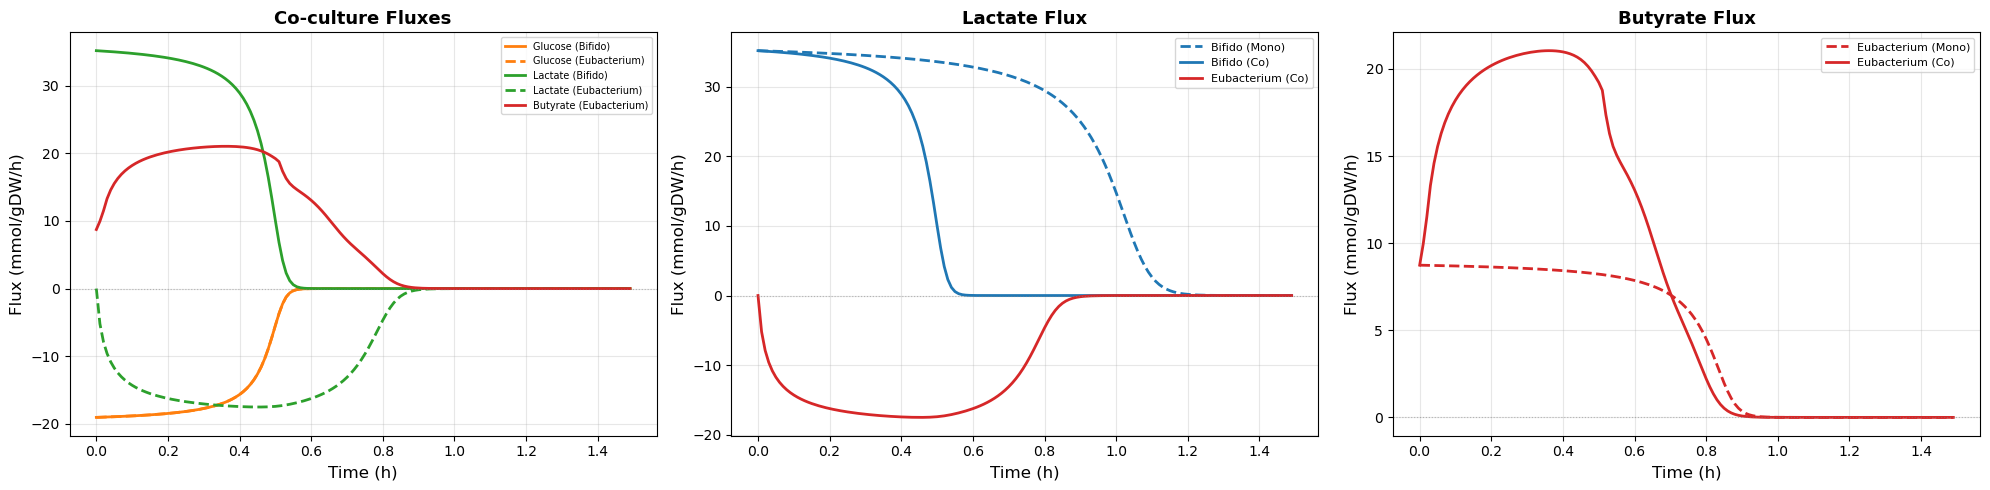

In [8]:
flux_bif_co = sim_co.get_species_exchange_fluxes('Bifido', threshold=1e-8)
flux_eub_co = sim_co.get_species_exchange_fluxes('Eubacterium', threshold=1e-8)
flux_bif_mono = sim_mono_Bifido.get_species_exchange_fluxes('Bifido', threshold=1e-8)
flux_eub_mono = sim_mono_Eubacterium.get_species_exchange_fluxes('Eubacterium', threshold=1e-8)

t_bif_co = np.arange(len(flux_bif_co)) * t_step
t_eub_co = np.arange(len(flux_eub_co)) * t_step
t_bif_mono = np.arange(len(flux_bif_mono)) * t_step
t_eub_mono = np.arange(len(flux_eub_mono)) * t_step

fig, axes = plt.subplots(1, 3, figsize=(20, 5))

C_BIF = '#1f77b4'
C_EUB = '#d62728'
C_GLC = '#ff7f0e'
C_LAC = '#2ca02c'
C_BUT = '#9467bd'
LS_CO   = '-'
LS_MONO = '--'

# Co-culture fluxes
ax = axes[0]
ax.plot(t_bif_co, flux_bif_co['EX_glc_D(e)'].values, color=C_GLC, ls=LS_CO, lw=2, label='Glucose (Bifido)')
ax.plot(t_eub_co, flux_eub_co['EX_glc_D(e)'].values, color=C_GLC, ls=LS_MONO, lw=2, label='Glucose (Eubacterium)')
ax.plot(t_bif_co, flux_bif_co['EX_lac_L(e)'].values, color=C_LAC, ls=LS_CO, lw=2, label='Lactate (Bifido)')
ax.plot(t_eub_co, flux_eub_co['EX_lac_L(e)'].values, color=C_LAC, ls=LS_MONO, lw=2, label='Lactate (Eubacterium)')
ax.plot(t_eub_co, flux_eub_co['EX_but(e)'].values, color=C_EUB, ls=LS_CO, lw=2, label='Butyrate (Eubacterium)')
ax.axhline(y=0, color='gray', ls=':', lw=0.8, alpha=0.5)
ax.set_xlabel('Time (h)', fontsize=12)
ax.set_ylabel('Flux (mmol/gDW/h)', fontsize=12)
ax.set_title('Co-culture Fluxes', fontsize=13, fontweight='bold')
ax.legend(fontsize=7)
ax.grid(True, alpha=0.3)

#Lactate flux
ax = axes[1]
ax.plot(t_bif_mono, flux_bif_mono['EX_lac_L(e)'].values, color=C_BIF, ls=LS_MONO, lw=2, label='Bifido (Mono)')
ax.plot(t_bif_co,   flux_bif_co['EX_lac_L(e)'].values,   color=C_BIF, ls=LS_CO,   lw=2, label='Bifido (Co)')
ax.plot(t_eub_co,   flux_eub_co['EX_lac_L(e)'].values,   color=C_EUB, ls=LS_CO,   lw=2, label='Eubacterium (Co)')
ax.axhline(y=0, color='gray', ls=':', lw=0.8, alpha=0.5)
ax.set_xlabel('Time (h)', fontsize=12)
ax.set_ylabel('Flux (mmol/gDW/h)', fontsize=12)
ax.set_title('Lactate Flux', fontsize=13, fontweight='bold')
ax.legend(fontsize=8)
ax.grid(True, alpha=0.3)

#  Butyrate flux 
ax = axes[2]
ax.plot(t_eub_mono, flux_eub_mono['EX_but(e)'].values, color=C_EUB, ls=LS_MONO, lw=2, label='Eubacterium (Mono)')
ax.plot(t_eub_co,   flux_eub_co['EX_but(e)'].values,   color=C_EUB, ls=LS_CO,   lw=2, label='Eubacterium (Co)')
ax.axhline(y=0, color='gray', ls=':', lw=0.8, alpha=0.5)
ax.set_xlabel('Time (h)', fontsize=12)
ax.set_ylabel('Flux (mmol/gDW/h)', fontsize=12)
ax.set_title('Butyrate Flux', fontsize=13, fontweight='bold')
ax.legend(fontsize=8)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('coculture_fluxes.png', dpi=150, bbox_inches='tight')
plt.show()